# Sign Language Translation Project
- Zoha Hassan, Dhathri Bathini, Sunayana Jain, Fiona Nicdao

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

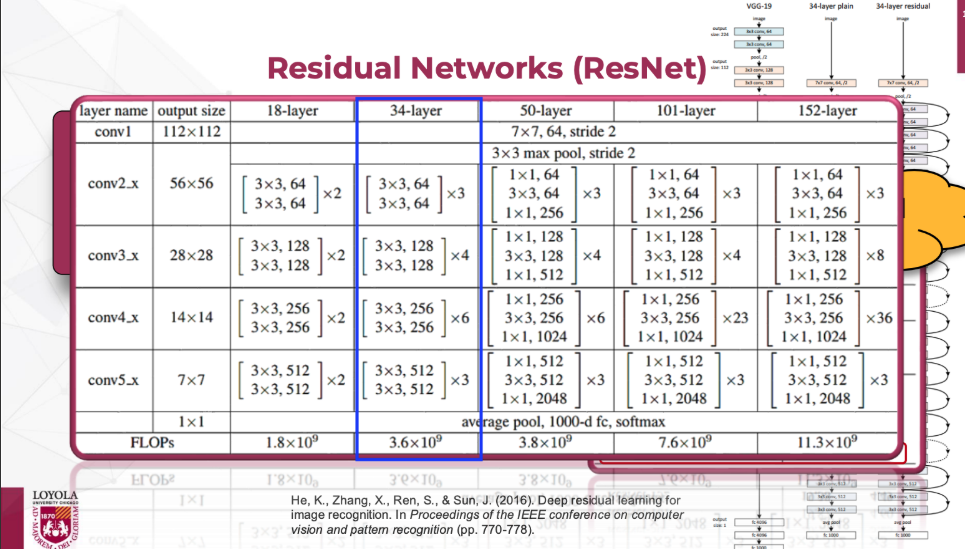

## Model : ResNet34

In [ ]:
#ResNet34
class Residual(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(Residual, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride))
        else:
            self.downsample = lambda x:x
    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        identity = self.downsample(inputs)
        output = tf.nn.relu(x + identity)
        return output

class Residual_block(tf.keras.layers.Layer):
    def __init__(self, filter_num, blocks, stride=1):
        super(Residual_block, self).__init__()
        self.blocks = tf.keras.Sequential()
        self.blocks.add(Residual(filter_num, stride))
        for _ in range(1, blocks):
            self.blocks.add(Residual(filter_num, stride=1))


    def call(self, inputs, training=None):
        output = self.blocks(inputs, training=training)
        return output

In [ ]:
class ResNet34(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')
        self.block1 = Residual_block(64,3,stride=1)
        self.block2 = Residual_block(128,4,stride=2)
        self.block3 = Residual_block(256,6,stride=2)
        self.block4 = Residual_block(512,3,stride=2)
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes)
    def call(self, inputs, training=None):
        x = self.conv(inputs)
        x = self.pool(x)
        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)
        x = self.pool2(x)
        x = self.fc(x)
        return x
    def build_model(self):
        x = tf.keras.layers.Input(shape=(224, 224, 1),batch_size=32)
        return tf.keras.models.Model(inputs=x, outputs=self.call(x))


## Loading the Data and Preprocessing
- training data = 27,455 samples
- testing data  =  7,172 samples
  - 20.7% of the total data

In [ ]:
# loading the test data
url_test = 'https://raw.githubusercontent.com/fiona1nicdao/signLanguageResnet34/refs/heads/main/sign_mnist_test.csv'
df_test = pd.read_csv(url_test)
print(df_test.head(5))

# load the training data
url_train = 'https://raw.githubusercontent.com/fiona1nicdao/signLanguageResnet34/refs/heads/main/sign_mnist_train.csv'
df_train = pd.read_csv(url_train)
print(df_train.head(1))

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     150   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   
3      0     203     205     207     206     207     209     210     209   
4      3     188     191     193     195     199     201     202     203   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     151  ...       138       148       127        89        82        96   
1     136  ...        47       104       194       183       186       184   
2     147  ...        68       166       242       227       230       227   
3     210  ...       154       248       247       248       253       236   
4     203  ...        26        40        64        48        29        46   

   pixel781  pixel782  pixel783  pixel784  
0       106       112       12

In [ ]:
# Extract images & original labels
train_images   = df_train.drop('label', axis=1).values.reshape(-1,28,28,1)
train_labels_o = df_train['label'].values
test_images    = df_test .drop('label', axis=1).values.reshape(-1,28,28,1)
test_labels_o  = df_test ['label'].values

print(train_images.shape)
print(train_labels_o.shape)
print(test_images.shape)
print(test_labels_o.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


In [ ]:
# Find the unique labels and build a mapping to 0…(num_unique‑1)
unique_labels = np.unique(train_labels_o)
label_map     = {orig: i for i, orig in enumerate(unique_labels)}

# Apply mapping
train_labels = np.array([label_map[x] for x in train_labels_o])
test_labels  = np.array([label_map[x] for x in test_labels_o])

# Now the number of classes is simply the number of uniques
num_classes = len(unique_labels)   # 24 in this dataset

In [ ]:
# Assuming X_train has image data and y_train has labels (0 to 25 for A-Z)
# And images are 28x28 (like MNIST)

# Create a dictionary to store one image per label
unique_signs = {}

for img, label in zip(train_images, train_labels):
    if label not in unique_signs:
        unique_signs[label] = img
    if len(unique_signs) == 26:  # We have all 26 letters
        break


# Plot the 26 unique images
plt.figure(figsize=(12, 6))
for i, (label, img) in enumerate(sorted(unique_signs.items())):
    plt.subplot(3, 9, i + 1)
    plt.imshow(img, cmap='gray')  # Use 'gray' if grayscale
    letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q',
               'R','S','T','U','V','W','X','Y']
    plt.title(letters[i])    # Convert 0–25 to A–Z
    plt.axis('off')

plt.tight_layout()
plt.show()

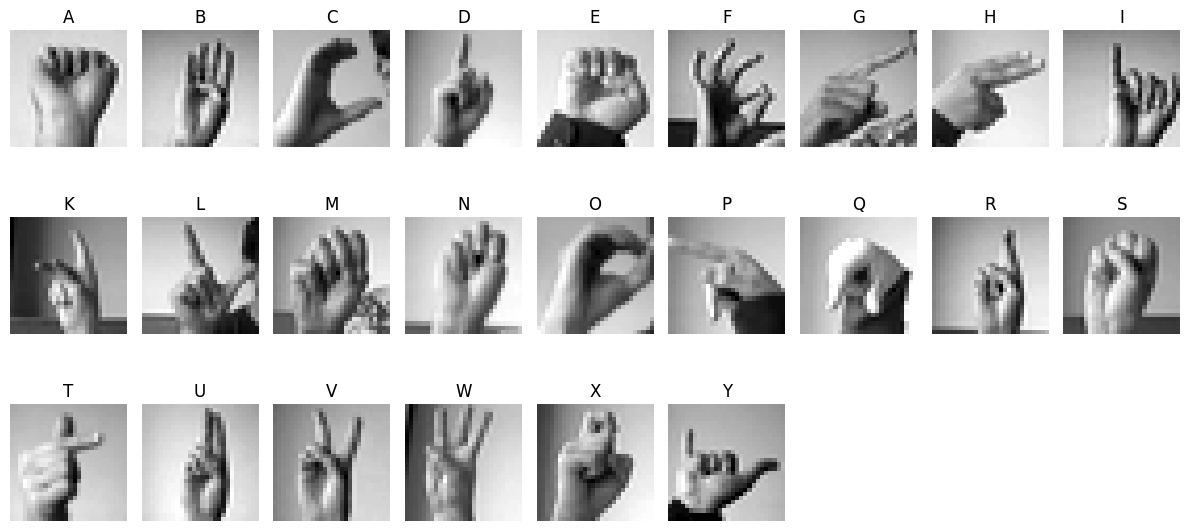

In [ ]:
# -------------------------------------------
# Prepare datasets (resize, normalize, one‑hot)
# -------------------------------------------
def preprocess(im, label):
    im = tf.image.resize(im, (224,224)) # resize
    im = tf.cast(im, tf.float32) / 255.0 # normalization
    return im, label

# One‑hot encode
train_labels_cat = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_cat  = tf.keras.utils.to_categorical(test_labels,  num_classes)

In [ ]:
# putting the dataset and labels together to make full dataset (full_ds)
full_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_cat))
full_ds = full_ds.shuffle(10_000).map(preprocess)

#vaidation set from the full dataset (full_ds) - 20% of the training dataset
val_size = int(0.2 * len(train_images))
val_ds   = full_ds.take(val_size).batch(32)
train_ds = full_ds.skip(val_size).batch(32)

#putting the test images and labels into test dataset (test_ds)
test_ds = (
    tf.data.Dataset
      .from_tensor_slices((test_images, test_labels_cat))
      .map(preprocess)
      .batch(32)
)

## Compiling

momentum: float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. 0 is vanilla gradient descent. Defaults to 0.0.

nesterov: boolean. Whether to apply Nesterov momentum. Defaults to False.

This is for faster convergence.

Below is a screenshot of runing the modeling without nesterov momentum and momentum at the default of 0.0

Accuracy was slower to achieve

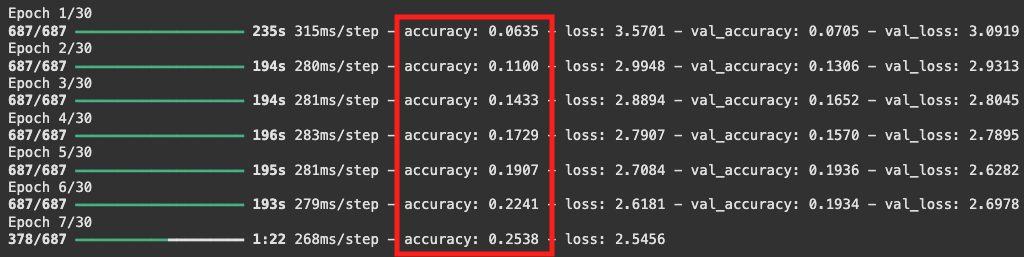

In [ ]:
# Instantiate the model & compile
resnet = ResNet34(num_classes)
model  = resnet.build_model()
model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-4,momentum=0.9,nesterov=True),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### EarlyStopping stops the model from overfitting
- monitor = 'val_loss' is the default
  - is the quantity being monitored
- patience = 5
 - number of epochs with no improvement after which training will be stopped. Defaults to 0.
- restore_best_weights = True (we want to test the model with the best weights)
 - Whether to restore model weights from the epoch with the best value of the monitored quantity. Default is False


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Data Augmentation
- to add randomization to the training images by randomly flipping the images, randomly rotating the images, and randomly zooming in or out the images.
- this helps prevent overfitting and increase generalization of the model

In [ ]:
# Data Augmentation
augment = tf.keras.Sequential([
          tf.keras.layers.RandomFlip(),
          tf.keras.layers.RandomRotation(0.1),
          tf.keras.layers.RandomZoom(0.1),
          ])

In [ ]:
history = model.fit(train_ds.map(lambda x,y:(augment(x),y)), epochs=30, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 163s 205ms/step - accuracy: 0.1076 - loss: 3.3055 - val_accuracy: 0.1681 - val_loss: 2.7974
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.3125 - loss: 2.2256 - val_accuracy: 0.2333 - val_loss: 2.6128
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.4913 - loss: 1.6265 - val_accuracy: 0.4010 - val_loss: 1.9397
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.6282 - loss: 1.1864 - val_accuracy: 0.4358 - val_loss: 1.9297
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 188ms/step - accuracy: 0.7442 - loss: 0.8398 - val_accuracy: 0.5777 - val_loss: 1.3274
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.8141 - loss: 0.6076 - val_accuracy: 0.6574 - val_loss: 1.3746
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.8731 - loss: 0.4418 - val_accuracy: 0.7026 - val_loss: 0.8858
Epoch 8/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.9044 -

## Visualizing the Results

### Plots for Training and Validation Dataset
- Right Side : Epoch vs Accuacy
- Left  Side : Epoch vs Loss

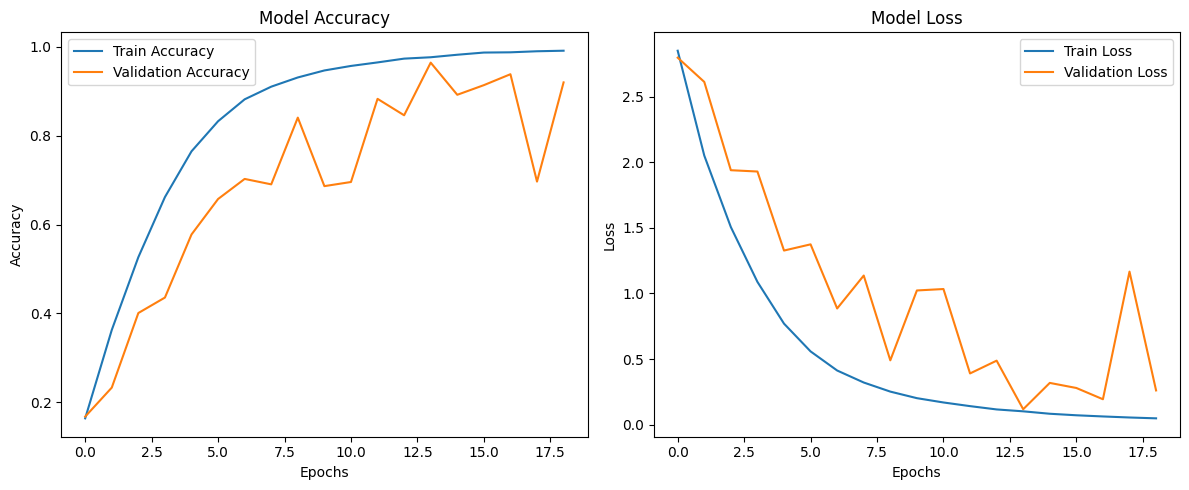

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Running the Model with the Test Dataset

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.9274 - loss: 0.2275
Test Accuracy: 92.39%


### Confusion Matrix
- Graphs the true class labels vs the predicted class labels
- Diagonal represents where the model made accurate predictions
- Darker shades represents better performance

Performance Metrics:
- Precision,  Recall,  F1-Score,  Accuracy

225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step


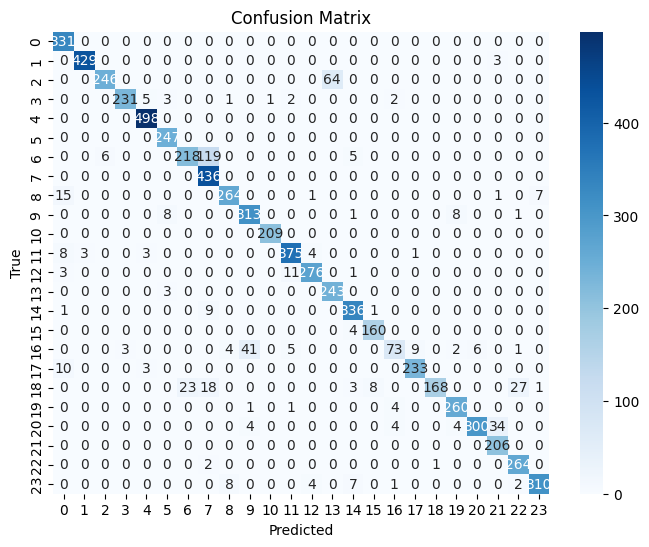

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       331
           1       0.99      0.99      0.99       432
           2       0.98      0.79      0.88       310
           3       0.99      0.94      0.96       245
           4       0.98      1.00      0.99       498
           5       0.95      1.00      0.97       247
           6       0.90      0.63      0.74       348
           7       0.75      1.00      0.85       436
           8       0.95      0.92      0.93       288
           9       0.87      0.95      0.91       331
          10       1.00      1.00      1.00       209
          11       0.95      0.95      0.95       394
          12       0.97      0.95      0.96       291
          13       0.79      0.99      0.88       246
          14       0.94      0.97      0.95       347
          15       0.95      0.98      0.96       164
          16       0.87      0.51      0.64       144
          17       0.96    

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions and true labels
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optional: Classification report
print(classification_report(y_true_classes, y_pred_classes))
